In [ ]:
"""
    Module nbpil -- Toolbox nbpil - notebook interface com PIL
    -------------------------------------------------------------------
    This module provides a link between numpy arrays and PIL, Python Imaging
    Library, images. Its functions perform image file I/O (in formats supported
    by PIL) and displaying of images represented as numpy arrays. The layout
    of these numpy arrays follows the rules of the adimage toolbox images.
    -------------------------------------------------------------------
    nbimages()    -- List image files located on sys.imagepath, if this variable
                     exists, or, otherwise, on sys.path
    nbread()      -- Read an image from a file to a numpy array.
    nbshow()      -- Display an image
    nbwrite()     -- Write an image from a numpy array to an image file. The
                     format is deduced from the filename extension.
    array2pil()   -- Convert a numpy array to a PIL image
    pil2array()   -- Convert a PIL image to a numpy array

"""
#
__version__ = '0.9 all'

__version_string__ = 'Toolbox nbpil V0.9 11Mar2017'

from io import StringIO, BytesIO
import IPython
from IPython.display import display, Image, HTML
import base64
import numpy as np
import PIL
from PIL import Image


#
# =====================================================================
#
#   Global statements for adread
#
# =====================================================================
def findImageFile(filename):
    '''Search image filename in sys.imagepath or sys.path.'''
    import sys, os.path
    if not os.path.isfile(filename) and not os.path.isabs(filename):
        try:
            for a in sys.imagepath:
                if os.path.isfile(os.path.join(a, filename)):
                    filename = os.path.join(a, filename)
                    break
        except:
            for a in sys.path:
                if os.path.isfile(os.path.join(a, filename)):
                    filename = os.path.join(a, filename)
                    break
    return filename
# =====================================================================
#
#   nbread
#
# =====================================================================
def nbread(imagefile):
    """
        - Purpose
            Read an image from a file to a numpy array.
        - Synopsis
            arr = nbread(imagefile)
        - Input
            imagefile: Image file path.
        - Output
            arr: numpy array representing an image.

    """

    image_path = findImageFile(imagefile)
    with Image.open(image_path) as image:         
        im_arr = np.fromstring(image.tobytes(), dtype=np.uint8)
        im_arr = im_arr.reshape((image.size[1], image.size[0], 3))                                   
    return im_arr
    
# =====================================================================
#
#   nbreadgray
#
# =====================================================================
def nbreadgray(imagefile):
    """
        - Purpose
            Read an image from a file to a numpy array as grayscale.
        - Synopsis
            arr = nbread(imagefile)
        - Input
            imagefile: Image file path.
        - Output
            arr: numpy array representing an image.

    """
    
    img = nbread(imagefile)
    f = img[:,:,0]*0.299 + img[:,:,1]*0.587 + img[:,:,2]*0.114
    return f
#
# =====================================================================
#
#   nbwrite
#
# =====================================================================
def nbwrite(imagefile, f):
    """
        - Purpose
            Write an image from a numpy array to an image file. The format
            is deduced from the filename extension.
        - Synopsis
            nbwrite(imagefile, arr)
        - Input
            imagefile: Image file path.
            f:         The numpy array to save.

    """
    fi = PIL.Image.fromarray(f)
    fi.save(imagefile)
    return
#
# =====================================================================
#
#   Global statements for nbimages
#
# =====================================================================
def listImageFiles(glb='*'):
    '''List image files located on sys.path.'''
    import sys, os.path, glob
    if os.path.splitext(glb)[1] == '':
        imgexts = ['.tif', '.jpg', '.gif', '.png', '.pbm', '.pgm', '.ppm', '.bmp']
    else:
        imgexts = ['']
    images = {}
    try:
        for dir in sys.imagepath:
            for ext in imgexts:
                for ff in glob.glob(os.path.join(dir, glb + ext)):
                    images[os.path.basename(ff)] = ff
    except:
        for dir in sys.path:
            for ext in imgexts:
                for ff in glob.glob(os.path.join(dir, glb + ext)):
                    images[os.path.basename(ff)] = ff
    return images
# =====================================================================
#
#   nbimages
#
# =====================================================================
def nbimages(glob='*'):
    """
        - Purpose
            List image files located on sys.imagepath, if this variable
            exists, or, otherwise, on sys.path
        - Synopsis
            imglist = nbimages(glob='*')
        - Input
            glob: Default: '*'. Glob string for the image filename.
        - Output
            imglist: Image filename list.

    """

    lst = list(listImageFiles(glob).keys())
    lst.sort()
    return lst

# =====================================================================
#
#   nbshow
#
# =====================================================================

class nbshow:
    #constructor
    def __init__(self, ncols = 3,width = [], fmt = 'png'):
        self.imgs = []
        self.titles = []
        self.ncols = ncols
        self.width = []   
        self.fmt = fmt
        return
    #sets figure size. Ex figsize = (12,8)
    def set_figsize(self,figsize):
        self.figsize = figsize
        return
    #sets image width
    def set_width(self,width):
        self.width = width
        return    
    #displays image in subplot format 
    #append images to list of images to be displayed
    def nbshow(self,img=None,title = "",flush=False):
        if img is not None:
            self.imgs.append(img)
            self.titles.append(title)
        if (img is None) or flush: 
            number_of_subplots = len(self.imgs)
            imagesList = "<head><style>\
                table, th, td { border: 0px solid black;\
                text-align: center;border-collapse: collapse;}</style></head>\
                <body><table border=\"0\">"
            for i,(img,title) in enumerate(zip(self.imgs,self.titles)): 
                if i%self.ncols == 0:
                    imagesList += "<tr>"
                if img.dtype == bool:
                    img = np.uint8(img) * 255
                elif img.dtype != np.uint8:
                    raise ValueError('Accept only bool ou uint8 image. It was %s with title:%s' % (img.dtype,title)) 
                #f = StringIO()
                f = BytesIO()
                # Verify format if (3,H,W), change to (H,W,3)
                if (img.ndim == 3) and (img.shape[0] == 3):
                    img = img.transpose((1,2,0))
                fi = PIL.Image.fromarray(img)
                fi.save(f, self.fmt)
                imgbuffer = f.getvalue()
                img_b64 = str(base64.b64encode(imgbuffer),'utf-8')
                imagesList +="<td>\
                    <table><tr><td><img src='data:image/png;base64,%s'/></td></tr>\
                    <tr><td align='center'>%s</td></tr></table></td>" % (img_b64,title)
                if i%self.ncols == (self.ncols-1):
                    imagesList += "<tr>"
            imagesList +="</tr></table></body>"
            # empties buffer
            self.imgs = []
            self.titles = []
            #print 'imagelist:',imagesList
            display(HTML(imagesList))

def show(a,fmt='png'):
    f = BytesIO()
    # Verify format if (3,H,W), change to (H,W,3)
    if (a.ndim == 3) and (a.shape[0] == 3):
        a = a.transpose((1,2,0))
    PIL.Image.fromarray(a).save(f, fmt)
    IPython.display.display(IPython.display.Image(data=f.getvalue()))
    
def adshow(img,title=""):
    imagesList = "<head><style>\
        table, th, td { border: 0px solid black;\
        text-align: center;border-collapse: collapse;}</style></head>\
        <body><table border=\"0\">"

    if img.dtype == bool:
        img = np.uint8(img) * 255
    elif img.dtype != np.uint8:
        raise ValueError('Accept only bool ou uint8 image. It was %s with title:%s' % (img.dtype,title)) 
    f = BytesIO()
    # Verify format if (3,H,W), change to (H,W,3)
    if (img.ndim == 3) and (img.shape[0] == 3):
        img = img.transpose((1,2,0))
    fi = PIL.Image.fromarray(img)
    fi.save(f, 'png')
    imgbuffer = f.getvalue()
    img_b64 = str(base64.b64encode(imgbuffer),'utf-8')
    imagesList +="<td>\
            <table><tr><td><img src='data:image/png;base64,%s'/></td></tr>\
            <tr><td align='center'>%s</td></tr></table></td>" % (img_b64,title)
    imagesList += "<tr>"
    imagesList +="</tr></table></body>"
    #print 'imagelist:',imagesList
    display(HTML(imagesList))
    
#


## Testing

In [1]:
testing = __name__ == "__main__"

if testing:
    #print ('name:',__name__)
    
    import numpy as np
    import sys,os
    ia898path = os.path.abspath('../..')
    if ia898path not in sys.path:
        sys.path.append(ia898path)
    import ia898.src as ia
    dir(ia)
    print('file:',ia.__file__)
    print(ia.__version__)

file: /Users/robertoalotufo/mylocalprojects/mylocalprojects/ia898/src/__init__.py
ia898 Python Toolbox for Teaching Image  Processing version 0.1 12Mar2017


""
teste

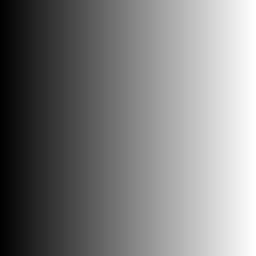

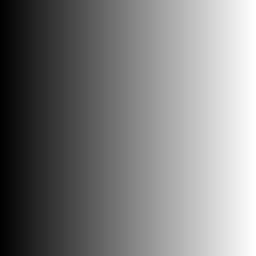

In [3]:
if testing:
    A = (np.arange(256*256) % 256).reshape(256,256).astype('uint8')
    ia.adshow(A,'teste')
    ia.show(A)

(3, 256, 256)


""
""

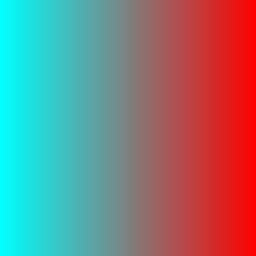

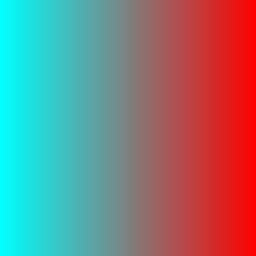

(256, 256, 3)


""
teste

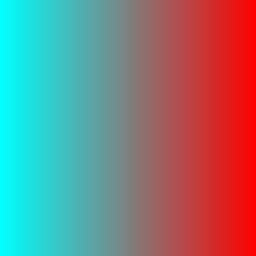

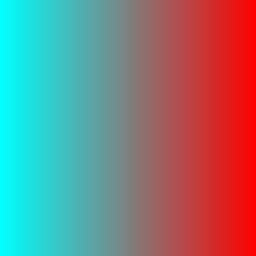

In [6]:
if testing:
    R = (np.arange(256*256) % 256).reshape(256,256).astype('uint8')
    G = 255-R
    B = R[:,::-1]
    rgb = np.array((R,G,B))
    print(rgb.shape)
    ia.adshow(rgb)
    ia.show(rgb)
    ff = rgb.transpose((1,2,0))
    print(ff.shape)
    ia.adshow(ff,'teste')
    ia.show(ff)

""
apenas uma

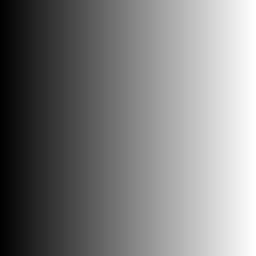

""
legenda 0
""
legenda 1
""
legenda 2
""
legenda 3

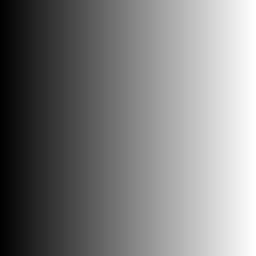
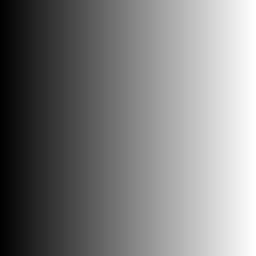
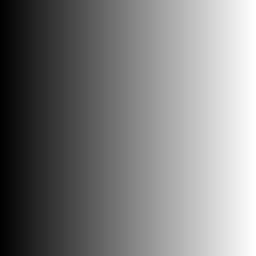
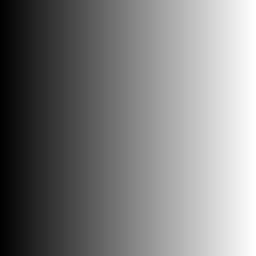

In [7]:
if testing:
    A = (np.arange(256*256) % 256).reshape(256,256).astype('uint8')
    nb = ia.nbshow(3)
    nb.nbshow(A,'apenas uma', flush=True)
    for i in range(4):
        nb.nbshow(A,'legenda %d' % (i,))
    nb.nbshow(flush=True)

""
apenas uma

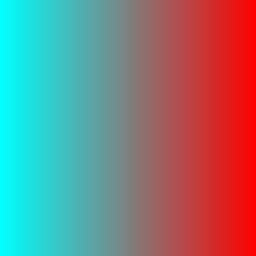

""
legenda 0
""
legenda 1
""
legenda 2
""
legenda 3

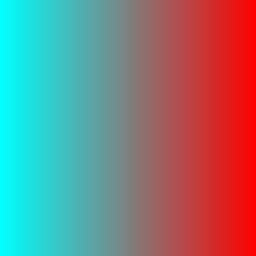
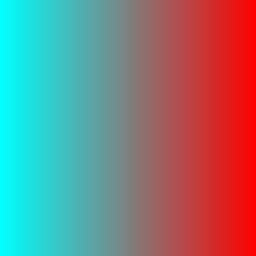
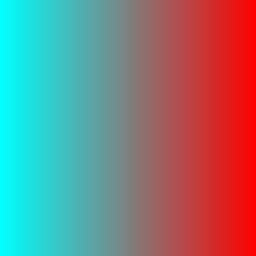
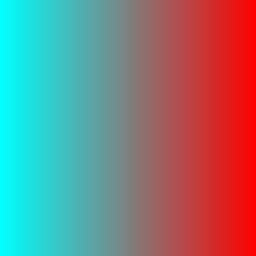

In [8]:
if testing:
    nb = ia.nbshow(3)
    nb.nbshow(ff,'apenas uma', flush=True)
    for i in range(4):
        nb.nbshow(rgb,'legenda %d' % (i,))
    nb.nbshow(flush=True)
    